In [1]:
from pract3_modules import load_custom_css
load_custom_css()

# <span class="bold-underline">Practical Application III: Comparing Classifiers</span>

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### **Getting Started**

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## <span class="bold-underline">Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

*The data contains information from 17 different marketing campaigns, conducted by a Portugese bank. The campaign was conducted primarily by phone, to customers in Portugal. Data contains features on customer information. The target is to see if the customer signed up for the promoted service.*

## <span class = "bold-underline">Problem 2: Read in the Data</span>

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
# Python library import block
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Encoders and other important functions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder # I tried TargetEncoder fro sklearn.preprocessing, but kept getting an 'out of memory' error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Custom functions from module
#from pract3_modules import top_bottom_frequencies # show the top and bottom N frequencies for a categorical column
from pract3_modules import cprint # colored print; makes some output a bit easier to read
from pract3_modules import plotColumnCounts # bar plots (categorical) or histograms (numerical) for columns
from pract3_modules import trim_feature # remove categories from a model if the total proportion represented is under a certain threshold (default: 1%)

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## <span class="bold-underline">Problem 3: Understanding the Features</span>


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Data notes:
- Remove 'duration'?
- May be no NAN data initially; missing data may be marked by "unknown". Check for this.

## <span class="bold-underline">Problem 4: Understanding the Task (Business Understanding)</span>
### <span class="bold-underline">Business Understanding</span>
After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

-------------------------------
<span class="bold-underline">**Determine Business Objectives:**</span> Banks are interested in maximizing ROI for all initiatives, including marketing campaigns. Maximizing ROI for marketing campaigns requires businesses to understand the characteristics of potential and current customers who are most likely to purchase new products and services. One way of getting this information is to datamine previous marketing campaigns for information regarding customers who did and did not purchase products and services after being targeted by the campaign. This analysis will use information from one such campaign to identify the profiles of those who are likely to accept a certain kind of financial service.

<span class="bold-underline">**Assess Situation:**</span> This analysis uses data, taken from published research, to examine the customer profiles of those who did and did not purchase the promoted service. I will be assuming that the final analysis and recommendations will be given to the original client who ran the campaign, for the purpose of future marketing efforts. Therefore, I will not be so concerned about how generalizable these findings may be across time, across cultures, across different socioeconomic strata, etc.

The key benefit from this analysis is the capacity to identify the customer characteristics that best predict whether a customer will purchase a certain class of service.

<span class="bold-underline">**Data Mining Goals:**</span> The goal of this project will be to identify the relationships between customer profile characteristics (predictors) and whether they purchased the promoted service (target). I will be comparing the efficacy and feasibility of using four different classifier models: K Nearest Neighbor (KNN), Decision Trees, Logistic Regression, and Support Vector Machines (SVMs). This will require a thorough evaluation of the dataset, identifying and possibly controlling for the bivaraiate and multivariate relationships between predictors, and making theoretically sound assumptions behind choosing which model to use to evaluate predictor-target relationships.

Data-mining will be successful if strong relationships can be found between customer characteristics and purchasing the service.

<span class="bold-underline">**Project Plan:**</span> The data has already been collected and partially cleaned. Therefore, only exploratory data analysis, further data cleaning, and data modeling are left. The project will consist of the aforementioned data preprocessing and data processing steps, as well as writing a summary of findings for presentation to the client (the Portugese banking institution).

## <span class="bold-underline">Data Understanding</span>

### <span class="bold-underline">Initial Data Cleaning</span>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# no missing values, but we know some "unknown" values exist--identify how many across columns
df_NAcheck = df.copy()
df_NAcheck.replace("unknown", np.nan, inplace=True)
missing_check = pd.DataFrame({'missing_values': df_NAcheck.isna().sum().sort_values(ascending = False),
                              'values_prop': df_NAcheck.isna().sum().sort_values(ascending = False)/df_NAcheck.shape[0]}
                            )
missing_check

,missing_values,values_prop
default,8597,0.208726
education,1731,0.042027
housing,990,0.024036
loan,990,0.024036
job,330,0.008012
marital,80,0.001942
age,0,0.000000
poutcome,0,0.000000
nr.employed,0,0.000000
euribor3m,0,0.000000


`default` is missing 20% of the values, `education`, `housing`, `loan`, `job`, and `marital` all missing < 5% of values.

Maybe `default` is because always has no loans?

In [8]:
df[['default', 'housing', 'loan']].value_counts()

default  housing  loan   
no       yes      no         14243
         no       no         12606
unknown  yes      no          3641
         no       no          3457
no       yes      yes         2968
         no       yes         2008
         unknown  unknown      763
unknown  yes      yes          723
         no       yes          549
         unknown  unknown      227
yes      no       no             2
         yes      no             1
Name: count, dtype: int64

Not the case. Lots of cases, and the 'unknown' status may be due to a systemic issue that has a relationship to target variable. Keep 'unknown' as a third category for `default`.

Take a look at the categorical counts for the other features.

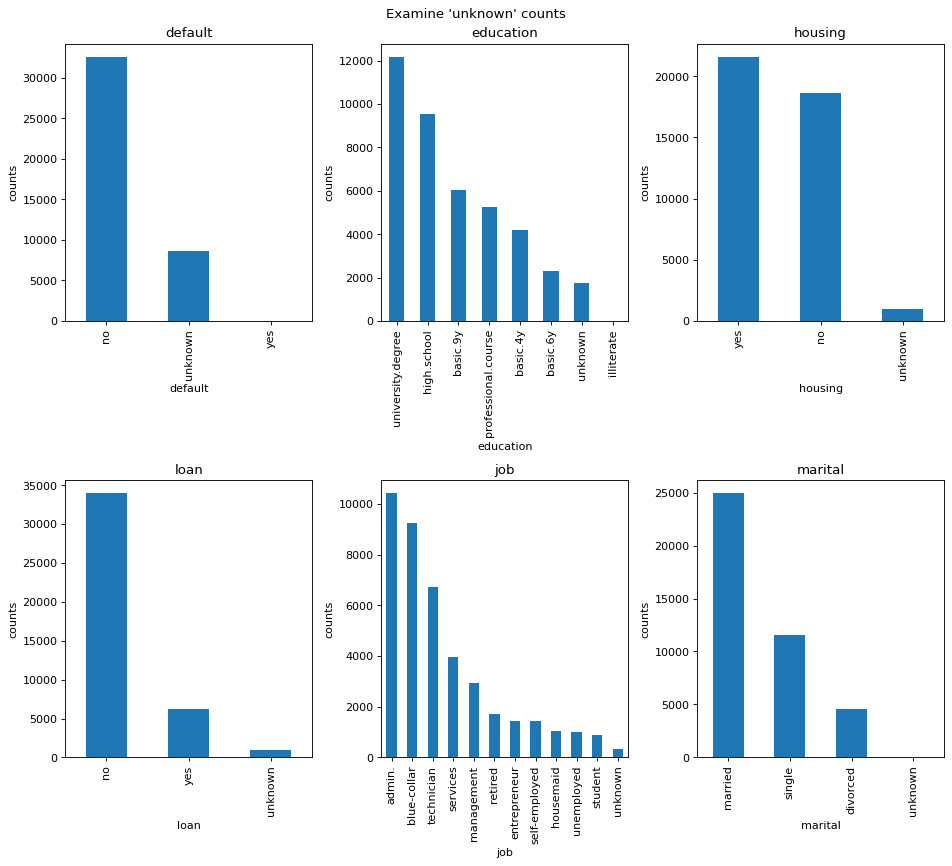

In [9]:
cols_with_unknown = ['default', 'education', 'housing', 'loan', 'job', 'marital']
plotColumnCounts(df, cols_with_unknown, number_graphs_per_row = 3, outlier_mask = False, stitle = "Examine 'unknown' counts", dropna = False, auto_show = True)

In [10]:
# Recreate df_NAcheck to make re-running the next few cells easier (for testing)
df_NAcheck = df.copy()
df_NAcheck.replace("unknown", np.nan, inplace=True)

In [11]:
# Try imputing missing values. Preprocessing:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoders = {}
mappings = {}

# Encode categorical columns and extract mappings, to re-convert to missing values
for column in df_NAcheck.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    # Store the original values
    original_values = df_NAcheck[column].astype(str)
    df_NAcheck[column] = le.fit_transform(original_values)
    label_encoders[column] = le
    # Create a mapping from original to encoded values
    mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

for column, mapping in mappings.items():
    if 'nan' in mapping:
        df_NAcheck[column].replace(mapping['nan'], np.nan, inplace=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_51916\1866499768.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_NAcheck[column].replace(mapping['nan'], np.nan, inplace=True)


In [12]:
df_NAcheck.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

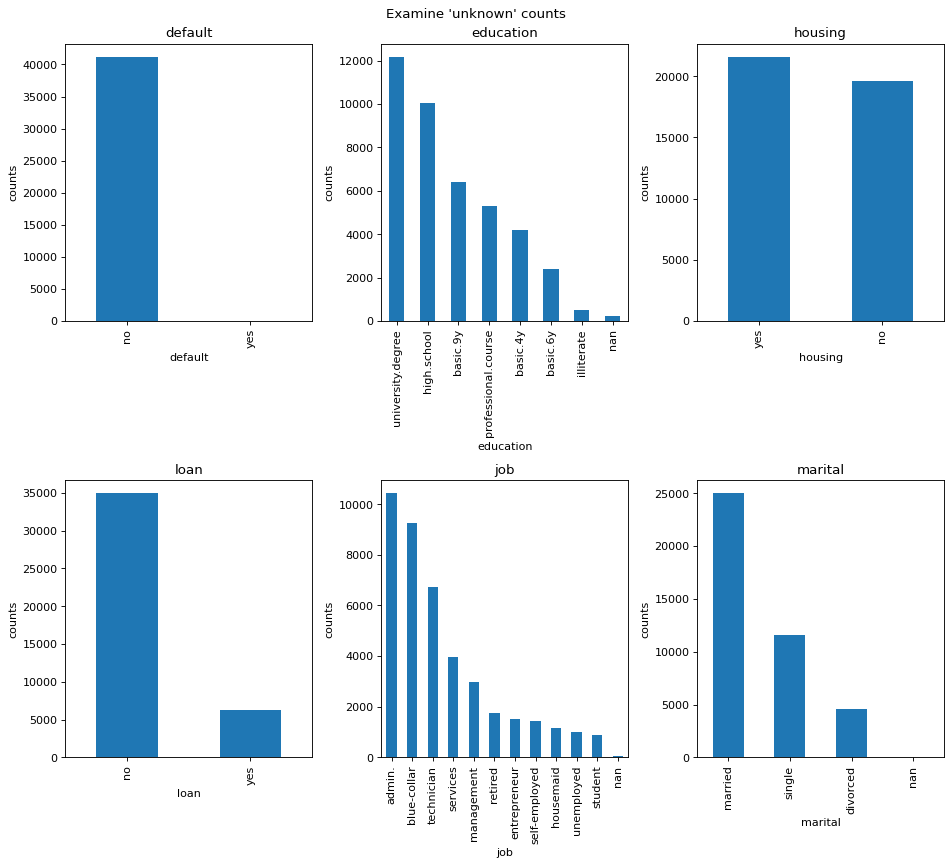

In [13]:
imputer = KNNImputer(n_neighbors = 10)
imputed_df = pd.DataFrame(imputer.fit_transform(df_NAcheck), columns = df_NAcheck.columns)

# decode
for column, le in label_encoders.items():
    imputed_df[column] = le.inverse_transform(imputed_df[column].astype(int))

plotColumnCounts(imputed_df, cols_with_unknown, number_graphs_per_row = 3, outlier_mask = False, stitle = "Examine 'unknown' counts", dropna = False, auto_show = True)

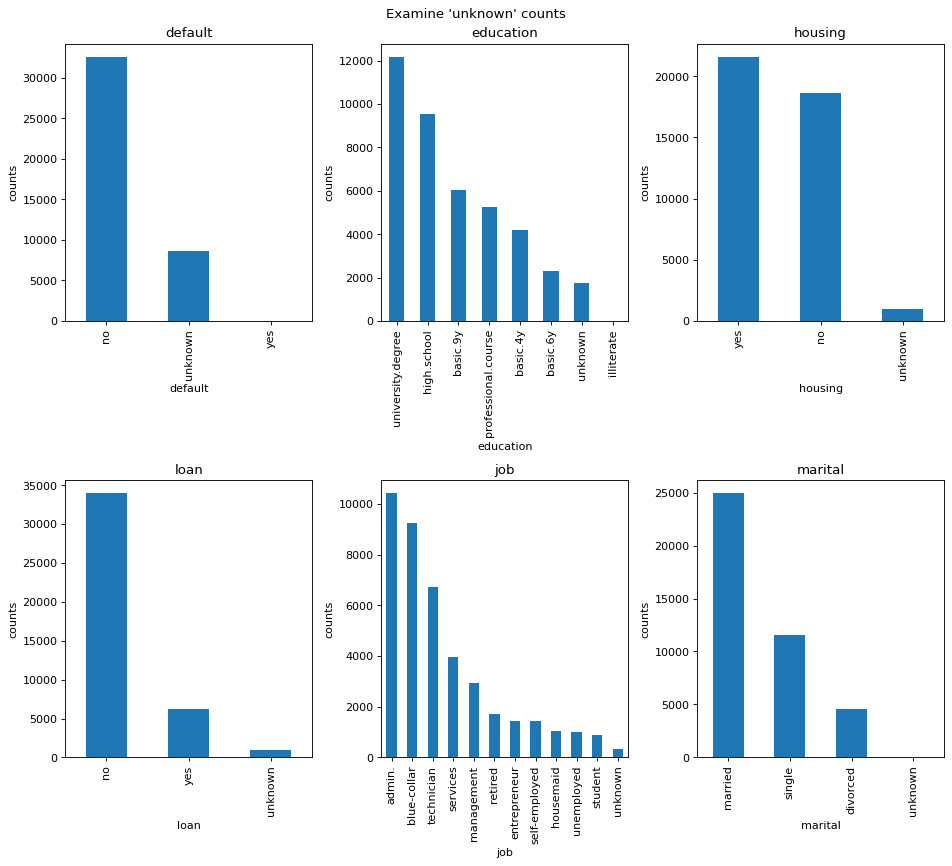

In [14]:
# compare to original columns
plotColumnCounts(df, cols_with_unknown, number_graphs_per_row = 3, outlier_mask = False, stitle = "Examine 'unknown' counts", dropna = False, auto_show = True)

Looks good enough. Drop any data that is still missing and move on.

In [15]:
df_clean = imputed_df.copy()
df_clean = df_clean.replace('nan', np.nan)
df_clean.dropna(inplace=True)
df_clean.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [16]:
# Any duplicates? If so, drop.
df_clean.duplicated().sum()

14

In [17]:
df_clean = df_clean.drop_duplicates()
df_clean.duplicated().sum()

0

## <span class="bold-underline">Problem 5: Engineering Features</span>

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### <span class="bold-underline">EDA</span>

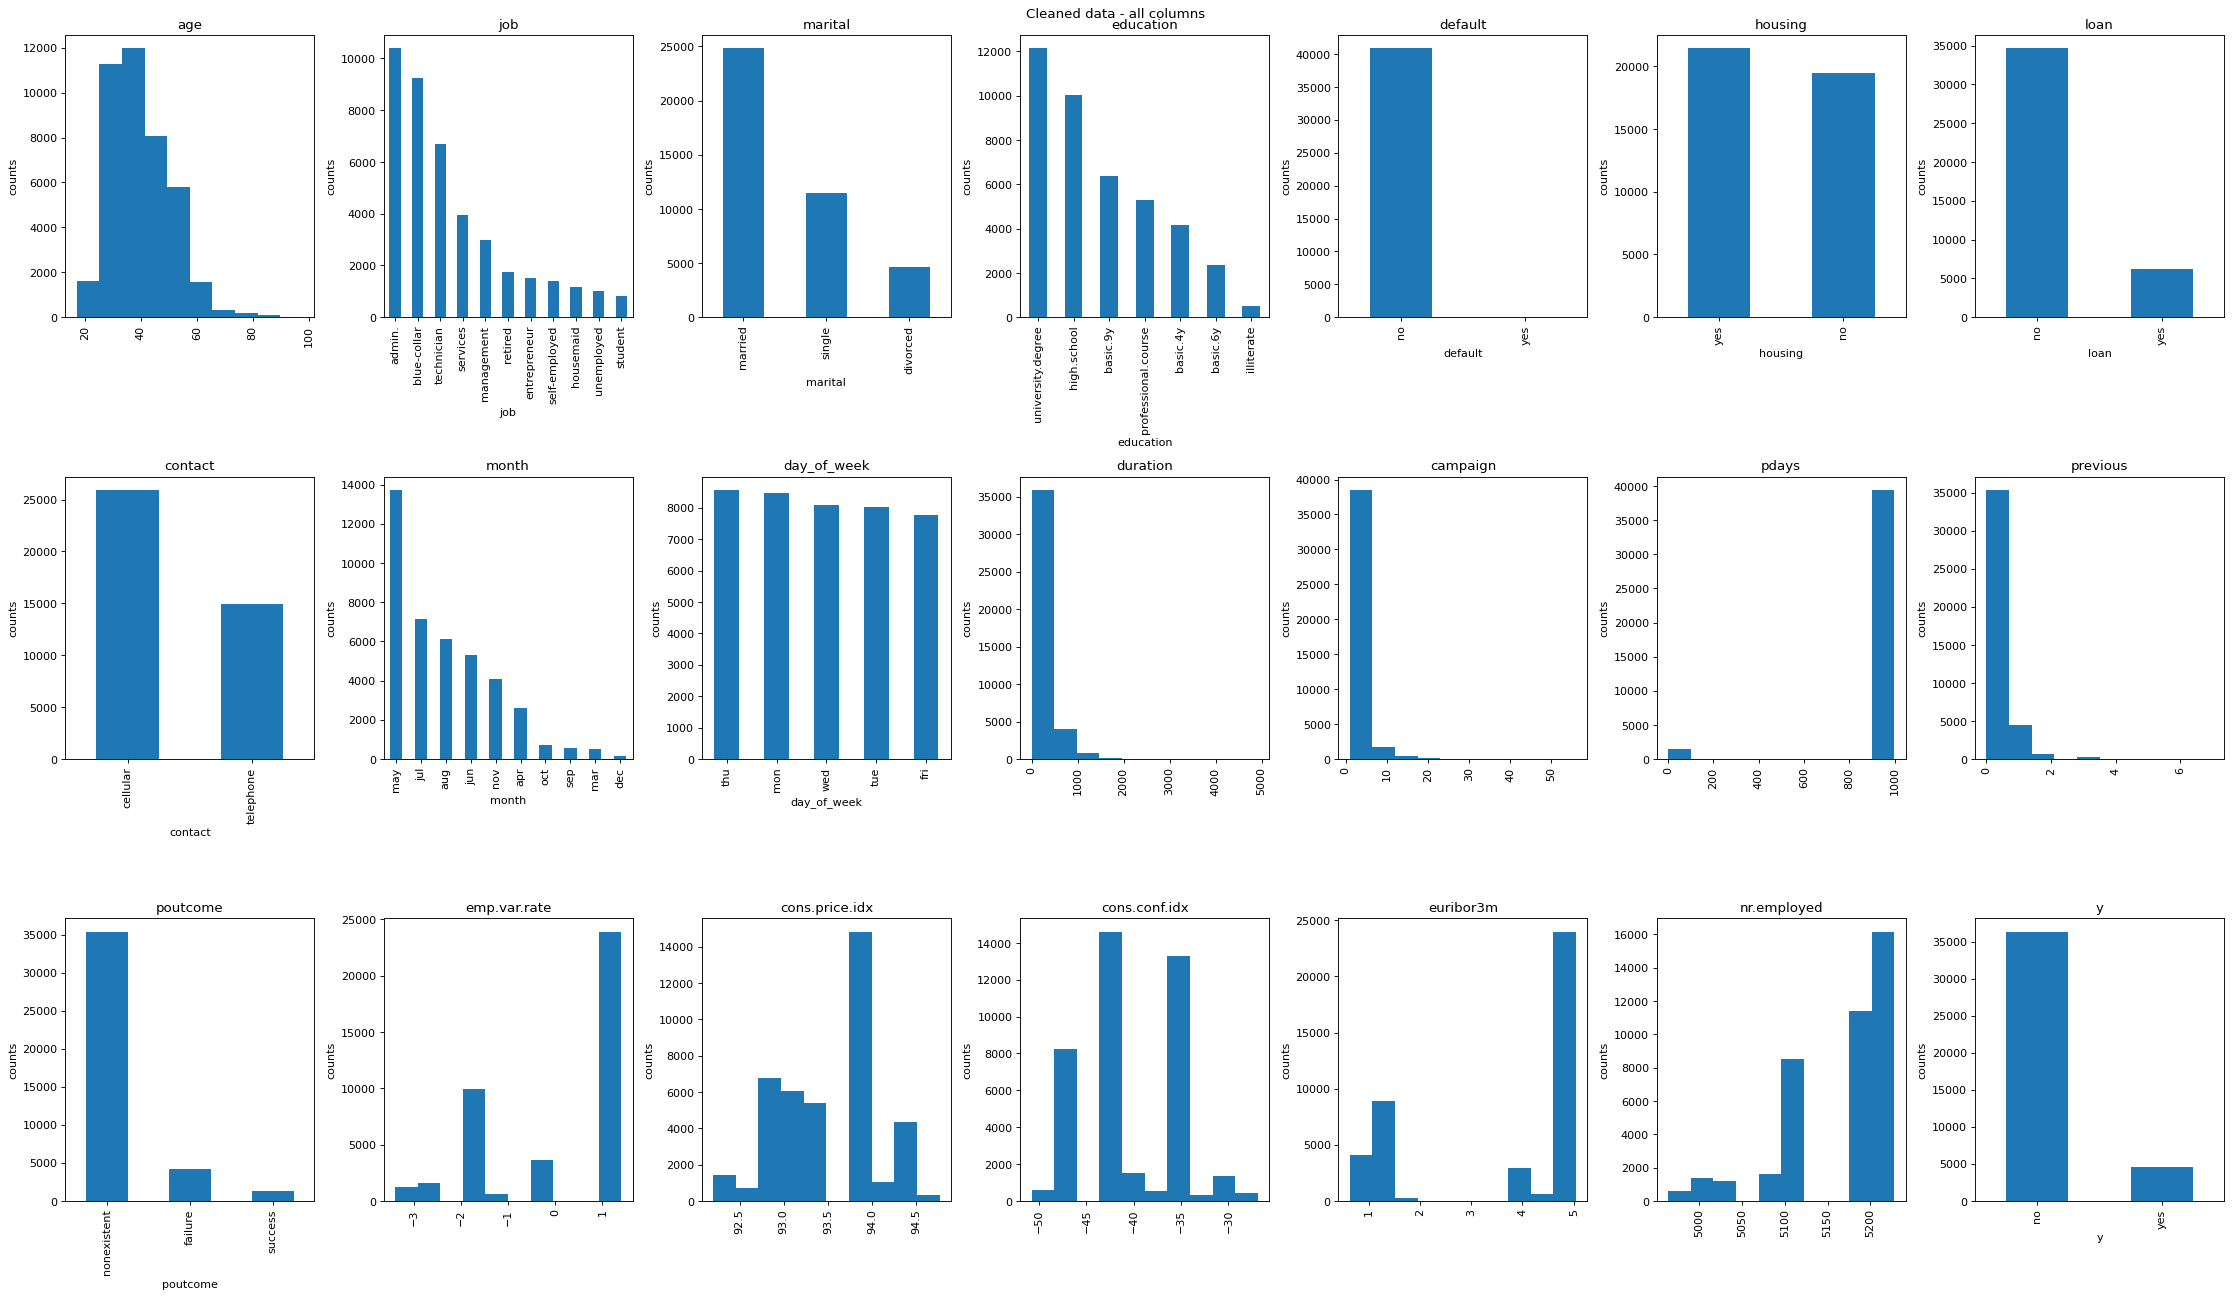

In [18]:
plotColumnCounts(df_clean, df_clean.columns, number_graphs_per_row = 7, stitle = 'Cleaned data - all columns')

`y` is a very unbalanced class, and is the target variable. Do the conditional distributions of other variables look similar between `y` == 'no' and `y` == 'yes'?

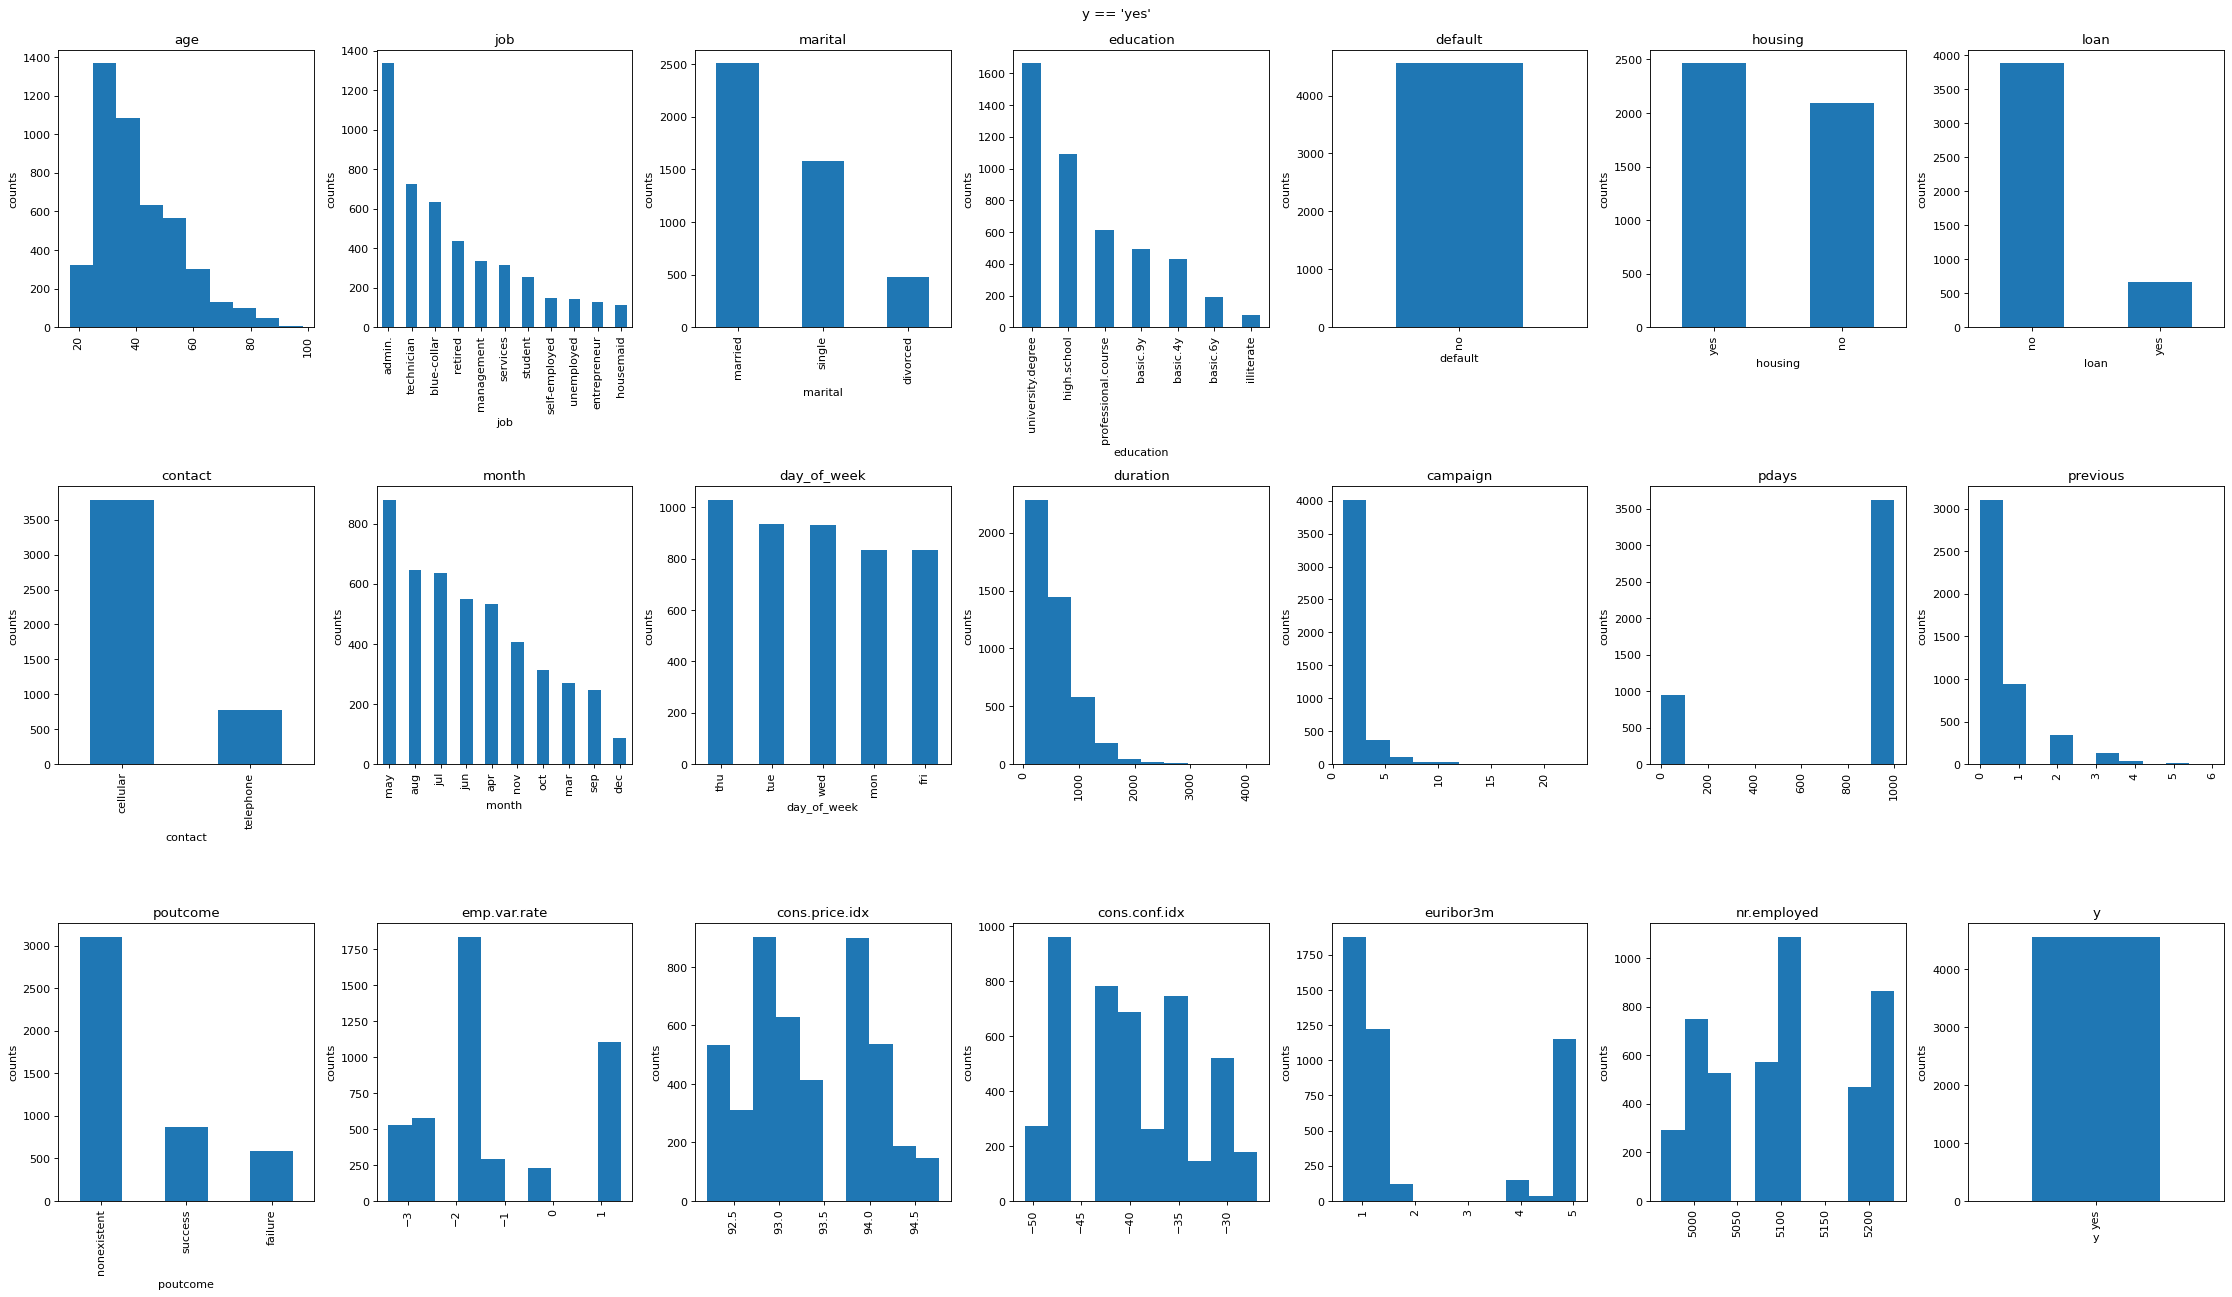

In [19]:
plotColumnCounts(df_clean[df_clean['y'] == 'yes'], df_clean.columns, number_graphs_per_row = 7, stitle= "y == 'yes'\n")

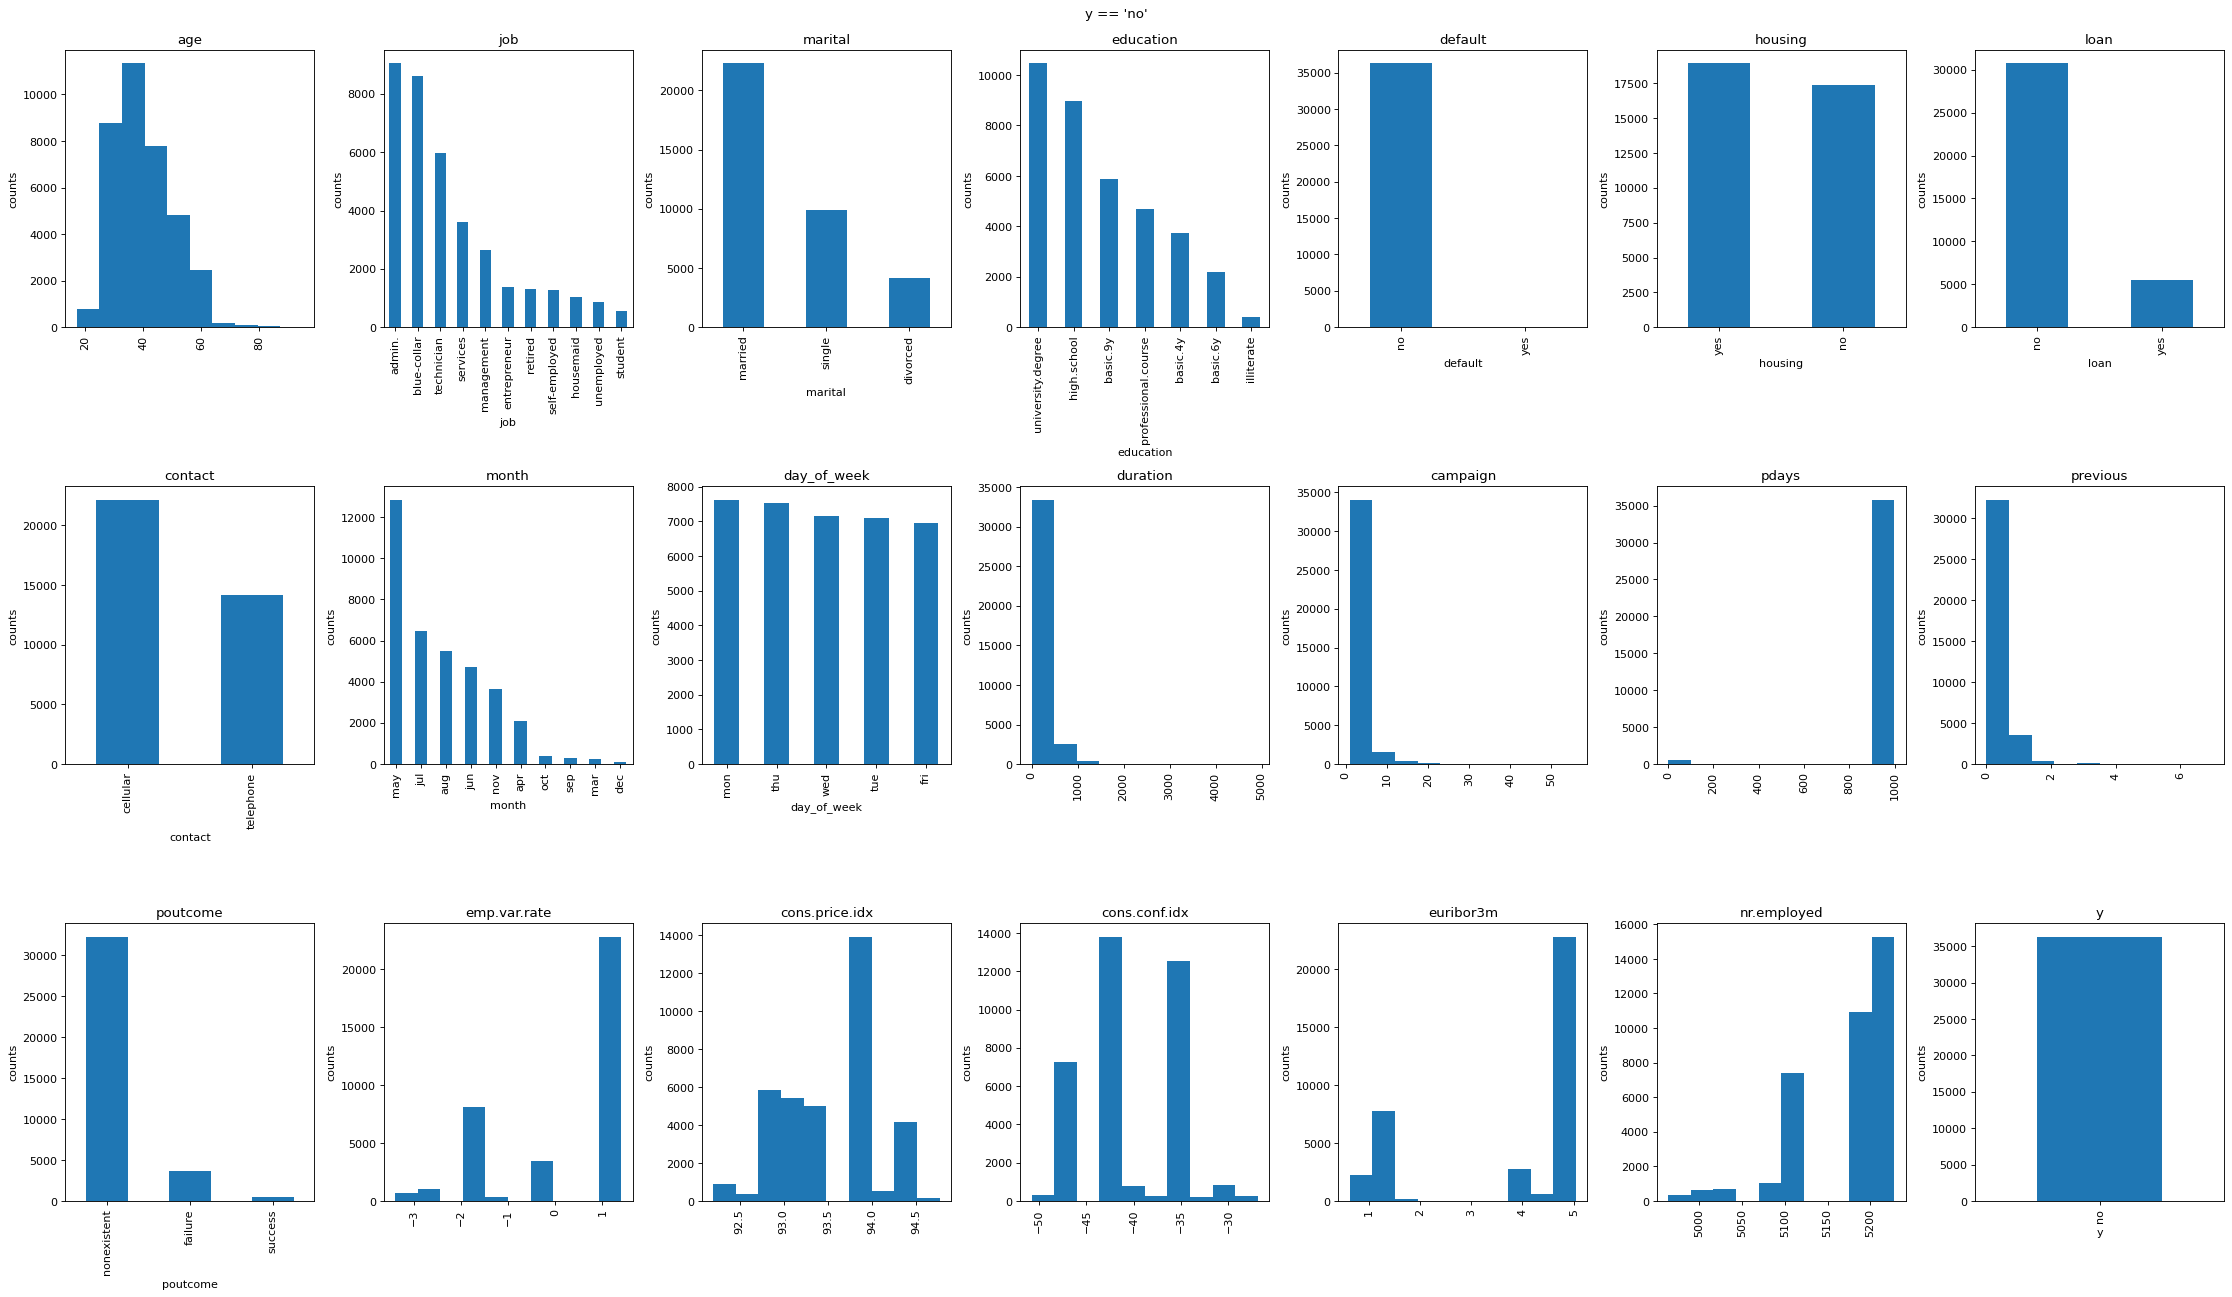

In [20]:
plotColumnCounts(df_clean[df_clean['y'] == 'no'], df_clean.columns, number_graphs_per_row = 7, stitle= "y == 'no'\n")

Before splitting into train/test sets, I will do the following:
**Feature transformations**:
- Convert `y` to numeric, with 1 == 'yes', to allow modeling and correlation analysis
- Remove:
    - `default` because it's almost entirely one value (extremely unbalanced class)
    - `duartion` becuase the data dictionary notes that it should be removed
- log-transform `age` and  to make more normal
- remove outliers (+/- 3 SDs) for:
    - `campaign`
    - `previous` 
- `pdays`: create a second column indicating whether someone was contacted or not, and change 999 in `pdays` to 'nan' values

**Object column encoding**:
- Decide how to encode object columns (detailed later)

**Dataset Transformations**:
- Examine whether I need to alter the dataset to account for the class imbalance in `y`

### <span class="bold-underline">Convert `y` to numeric</span>

In [21]:
# reassign `df`
df = df_clean.copy()
df = df.drop(['default', 'duration'], axis=1)

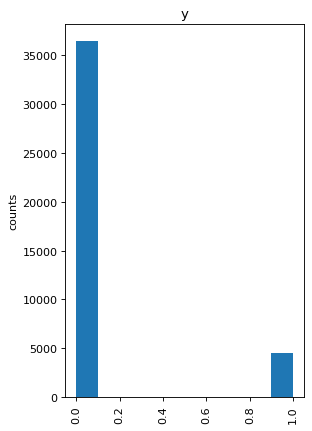

In [22]:
df['y'] = df['y'].map({"yes": 1, "no": 0})
plotColumnCounts(df, ['y'])

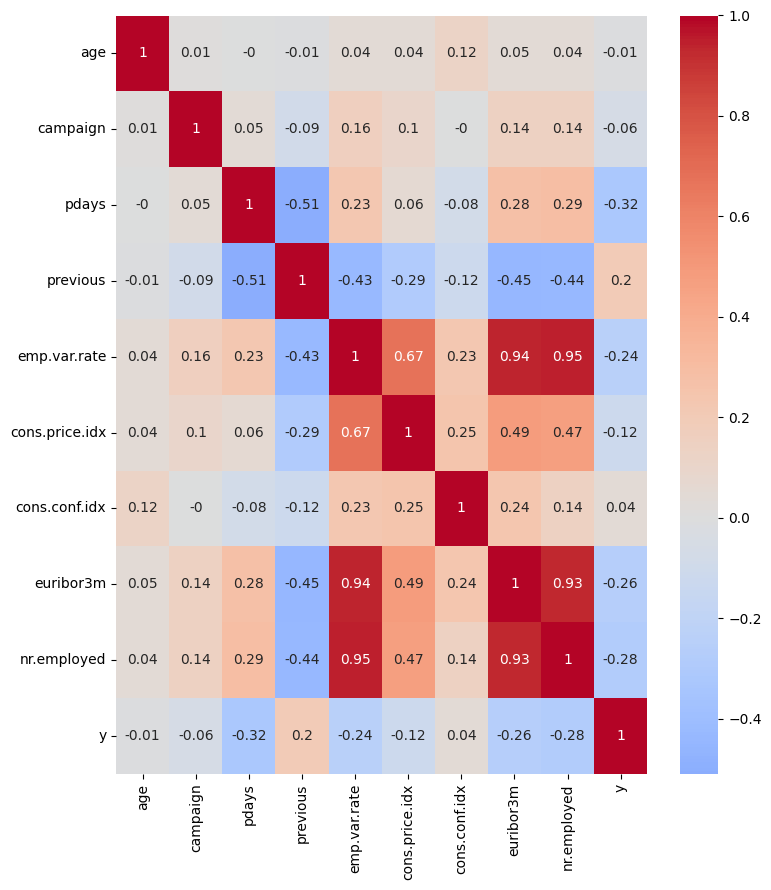

In [23]:
# check relationship b/t y and other numeric variables
plt.figure(figsize = (8, 9))
sns.heatmap(np.round(df.select_dtypes(include = ['number']).corr(method = 'spearman'), 2), annot = True, center = 0, cmap = "coolwarm")
plt.savefig('initial_corr.png')
plt.tight_layout()

### <span class="bold-underline">Remove & log-xform</span>

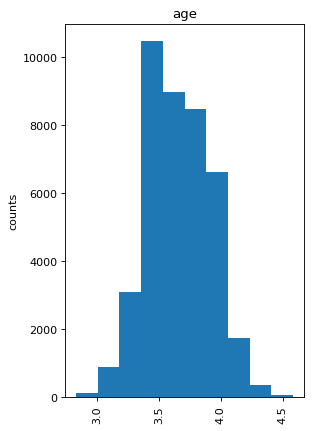

In [24]:
df['age'] = np.log(df['age'])

plotColumnCounts(df, ['age'])

In [25]:
df[['age', 'y']].corr(method='spearman')

,age,y
age,1.000000,-0.009557
y,-0.009557,1.000000


### <span class="bold-underline">Remove outliers</span>

In [26]:
# campaign and previous both are measures of contact with customers; check to see if they have a high correlation, since we might expect them to be
df[['campaign', 'previous', 'y']].corr(method='spearman')

,campaign,previous,y
campaign,1.000000,-0.085791,-0.062300
previous,-0.085791,1.000000,0.198006
y,-0.062300,0.198006,1.000000


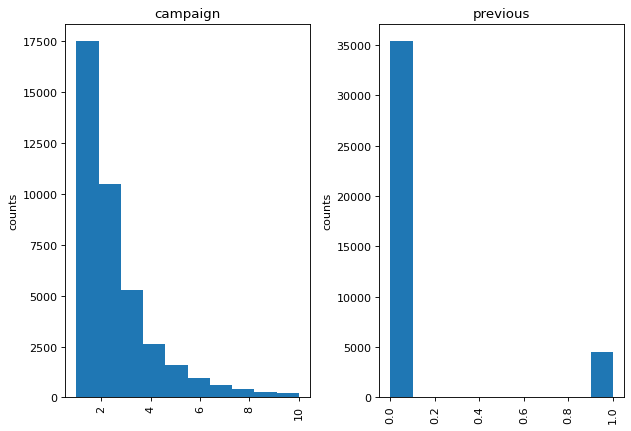

In [27]:
# correlation b/t campaign and previous is very small, surprisingly. Continue with both.

for column in ['campaign', 'previous']:
    col_mean = df[column].mean()
    col_sd = df[column].std()
    high_outlier = col_mean + 3*col_sd
    low_outlier = col_mean - 3*col_sd
    df[column] = df[column].apply(lambda x: x if low_outlier < x < high_outlier else np.nan)

df.isna().sum()
plotColumnCounts(df, ['campaign', 'previous'])

Does `previous` have a good correlation with target? Check; drop if not, b/c a very unbalanced class. Also, log-transform campaign now.

In [28]:
df[['previous','y']].corr(method = 'spearman')

,previous,y
previous,1.00000,0.12767
y,0.12767,1.00000


In [29]:
# correlation dropped significantly--reinstate original column for `previous`
df['previous'] = df_clean['previous']
df.isna().sum()

age                 0
job                 0
marital             0
education           0
housing             0
loan                0
contact             0
month               0
day_of_week         0
campaign          862
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

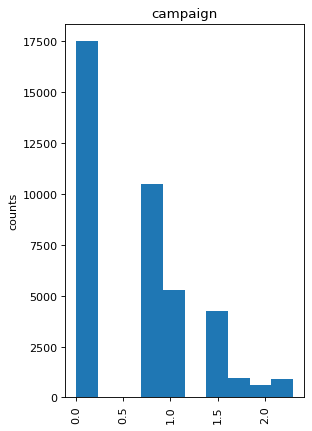

In [30]:
# drop missing values and then log-transform `campaign`
df = df.dropna()
df['campaign'] = np.log(df.loc[:,'campaign'])
plotColumnCounts(df, ['campaign'])

In [31]:
df[['campaign', 'previous', 'y']].corr(method = 'spearman')

,campaign,previous,y
campaign,1.000000,-0.074556,-0.054590
previous,-0.074556,1.000000,0.197451
y,-0.054590,0.197451,1.000000


### <span class="bold-underline">Transform `pdays`</span>

In [32]:
df['pdays'].value_counts()

pdays
999.0    38563
3.0        428
6.0        402
4.0        114
9.0         62
2.0         61
7.0         58
12.0        57
10.0        51
5.0         45
13.0        34
11.0        28
1.0         26
15.0        23
14.0        19
8.0         17
0.0         15
16.0         9
17.0         7
18.0         6
22.0         3
19.0         3
21.0         2
25.0         1
26.0         1
27.0         1
Name: count, dtype: int64

In [33]:
# `pdays` has a strong negative correlation with `y`, but most of the values are 999 which signify no contact. What if we remove those values--is there any useful information left?
df['pdays'] = df['pdays'].apply(lambda x: x if x < 999 else np.nan)
df[['pdays', 'y']].corr(method = 'spearman')

,pdays,y
pdays,1.000000,-0.021195
y,-0.021195,1.000000


In [34]:
# Not much useful information left. It seems that the strong correlation is due to the 999 values. Let's check that.
df['pdays'] = df_clean.loc[:,'pdays']
df['pdays'] = df['pdays'].apply(lambda x: 1 if x == 999 else 0)
df[['pdays', 'y']].corr(method = 'spearman')

,pdays,y
pdays,1.000000,-0.323635
y,-0.323635,1.000000


It looks like the strength of pday as a predictor comes from the 'no contact' information. Transform 'pdays' into a binary variable predicting whether someone was contacted or not, then check correlations b/t `pday` and `previous`, and both with `y`.

In [35]:
df['pdays'] = df_clean.loc[:,'pdays']
df['pdays_binary'] = df['pdays'].apply(lambda x: 1 if x == 999 else 0)
df[['pdays_binary', 'previous', 'y']].corr(method = 'spearman')

,pdays_binary,previous,y
pdays_binary,1.000000,-0.507058,-0.323635
previous,-0.507058,1.000000,0.197451
y,-0.323635,0.197451,1.000000


In [36]:
# Check the parameters for both in a mulitple regression equation
from sklearn.linear_model import LinearRegression
scaler = StandardScaler()
X = scaler.fit_transform(df[['pdays_binary', 'previous']])
y = df['y']

model = LinearRegression()
model.fit(X, y)
model.coef_

array([-0.091929 ,  0.0181891])

Both still have some predictive power -- keep them both in the analysis.

<span class="bold-underline">Final features:</span>
- Numeric:
    - `age`, `campaign`, `pdays_binary`, `previous`, `emp.var.var`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`
- Object:
    - `job`, `marital`, `education`, `housing`, `loan`, `contact`, `month`, `day_of_week`, `poutcome`

In [37]:
# create column names for use later and X and y
X_columns = ['age', 'campaign', 'pdays_binary', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
            'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
X, y = df[X_columns], df['y']

### <span class="bold-underline">Dataset Transformation</span>
Now that feature transformation is complete, I want to examine whether it is necessary to alter the dataset to balance the class ratios of `y`. I want to get a 75:25 ratio at least.

In [38]:
pd.DataFrame({'counts': df['y'].value_counts(), 'prop': df['y'].value_counts(normalize = True)})

,counts,prop
y,,
0,35500,0.886702
1,4536,0.113298


Dropping that many rows would be a big issue, I think, but duplicating the lesser class with SMOTE would work.

In [39]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC

X, y = df[X_columns], df['y']

object_features = df.select_dtypes(include = ['object']).columns

label_encoders = {}
mappings = {}

for column in object_features:
    le = LabelEncoder()
    X[column] = le.fit_transform(X.loc[:,column])
    label_encoders[column] = le
    mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

C:\Users\matth\AppData\Local\Temp\ipykernel_51916\2340643884.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X.loc[:,column])
C:\Users\matth\AppData\Local\Temp\ipykernel_51916\2340643884.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X.loc[:,column])
C:\Users\matth\AppData\Local\Temp\ipykernel_51916\2340643884.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [40]:
object_indices = [X.columns.get_loc(col) for col in object_features]

smotenc = SMOTENC(categorical_features = object_indices, sampling_strategy = 0.3334, random_state = 42)
X_resampled, y_resampled = smotenc.fit_resample(X, y)

In [41]:
y_resampled.value_counts(normalize=True)

y
0    0.749974
1    0.250026
Name: proportion, dtype: float64

In [42]:
label_encoders.items()

dict_items([('job', LabelEncoder()), ('marital', LabelEncoder()), ('education', LabelEncoder()), ('housing', LabelEncoder()), ('loan', LabelEncoder()), ('contact', LabelEncoder()), ('month', LabelEncoder()), ('day_of_week', LabelEncoder()), ('poutcome', LabelEncoder())])

In [43]:
# decode
for column, le in label_encoders.items():
    X_resampled[column] = le.inverse_transform(X_resampled[column].astype(int))

X_resampled

,age,campaign,pdays_binary,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,housing,loan,contact,month,day_of_week,poutcome
0,4.025352,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,housemaid,married,basic.4y,no,no,telephone,may,mon,nonexistent
1,4.043051,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,no,no,telephone,may,mon,nonexistent
2,3.610918,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,yes,no,telephone,may,mon,nonexistent
3,3.688879,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,admin.,married,basic.6y,no,no,telephone,may,mon,nonexistent
4,4.025352,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47330,3.825583,1.633297,1,0.0,1.1,93.994,-36.4,4.857131,5191.0,services,divorced,high.school,yes,no,telephone,may,mon,nonexistent
47331,3.204977,0.000000,1,0.0,-2.9,92.201,-31.4,0.881000,5076.2,student,single,high.school,yes,no,cellular,aug,fri,nonexistent
47332,3.613179,0.000000,1,0.0,-3.4,92.379,-29.8,0.773000,5017.5,admin.,married,high.school,yes,no,cellular,sep,fri,nonexistent
47333,3.136242,1.351285,1,0.0,-1.8,93.075,-47.1,1.405000,5099.1,student,single,high.school,no,no,cellular,apr,mon,nonexistent


In [44]:
# compare ratios of object_feature cols in df and X_resampled to make sure everything is still correct
for column in object_features:
    temp = pd.concat([df[column].value_counts(normalize=True), X_resampled[column].value_counts(normalize = True)], axis = 1)
    temp['diff'] = temp.iloc[:,0]-temp.iloc[:,1]
    print(temp)

               proportion  proportion      diff
job                                            
admin.           0.253572    0.278990 -0.025418
blue-collar      0.226471    0.213542  0.012929
technician       0.163828    0.163706  0.000122
services         0.096413    0.089828  0.006585
management       0.073034    0.069082  0.003952
retired          0.042537    0.050280 -0.007743
entrepreneur     0.036842    0.033083  0.003759
self-employed    0.034619    0.030971  0.003648
housemaid        0.028100    0.024654  0.003446
unemployed       0.024528    0.022309  0.002219
student          0.020057    0.023556 -0.003499
          proportion  proportion      diff
marital                                   
married     0.607179    0.607922 -0.000744
single      0.279898    0.289574 -0.009676
divorced    0.112923    0.102503  0.010420
                     proportion  proportion      diff
education                                            
university.degree      0.296933    0.320186 -0.023253

The resampling technique seemed to work--75:25 ratio in `y` and similar proportions for X across the original and resampled DataFrames. Can continue with the analysis with a new df.

In [45]:
df = pd.concat([X_resampled, y_resampled], axis = 1)
df

,age,campaign,pdays_binary,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y
0,4.025352,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,housemaid,married,basic.4y,no,no,telephone,may,mon,nonexistent,0
1,4.043051,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,no,no,telephone,may,mon,nonexistent,0
2,3.610918,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,yes,no,telephone,may,mon,nonexistent,0
3,3.688879,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,admin.,married,basic.6y,no,no,telephone,may,mon,nonexistent,0
4,4.025352,0.000000,1,0.0,1.1,93.994,-36.4,4.857000,5191.0,services,married,high.school,no,yes,telephone,may,mon,nonexistent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47330,3.825583,1.633297,1,0.0,1.1,93.994,-36.4,4.857131,5191.0,services,divorced,high.school,yes,no,telephone,may,mon,nonexistent,1
47331,3.204977,0.000000,1,0.0,-2.9,92.201,-31.4,0.881000,5076.2,student,single,high.school,yes,no,cellular,aug,fri,nonexistent,1
47332,3.613179,0.000000,1,0.0,-3.4,92.379,-29.8,0.773000,5017.5,admin.,married,high.school,yes,no,cellular,sep,fri,nonexistent,1
47333,3.136242,1.351285,1,0.0,-1.8,93.075,-47.1,1.405000,5099.1,student,single,high.school,no,no,cellular,apr,mon,nonexistent,1


In [46]:
df.isna().sum()

age               0
campaign          0
pdays_binary      0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
job               0
marital           0
education         0
housing           0
loan              0
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64

## <span class="bold-underline">Problem 6: Train/Test Split</span>

With the data prepared, the next steps are:
- Transform data into a test and training set
- Identify objects for object encoding (OneHotEncoding and TargetEncoding)
- Create column encoder

In [47]:
# train-test split here, then object column encoding
X, y = df[X_columns], df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

pd.concat([y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)], axis = 1)

,proportion,proportion
y,,
0,0.749974,0.749974
1,0.250026,0.250026


### <span class="bold-underline">Object Column Encoding</span>

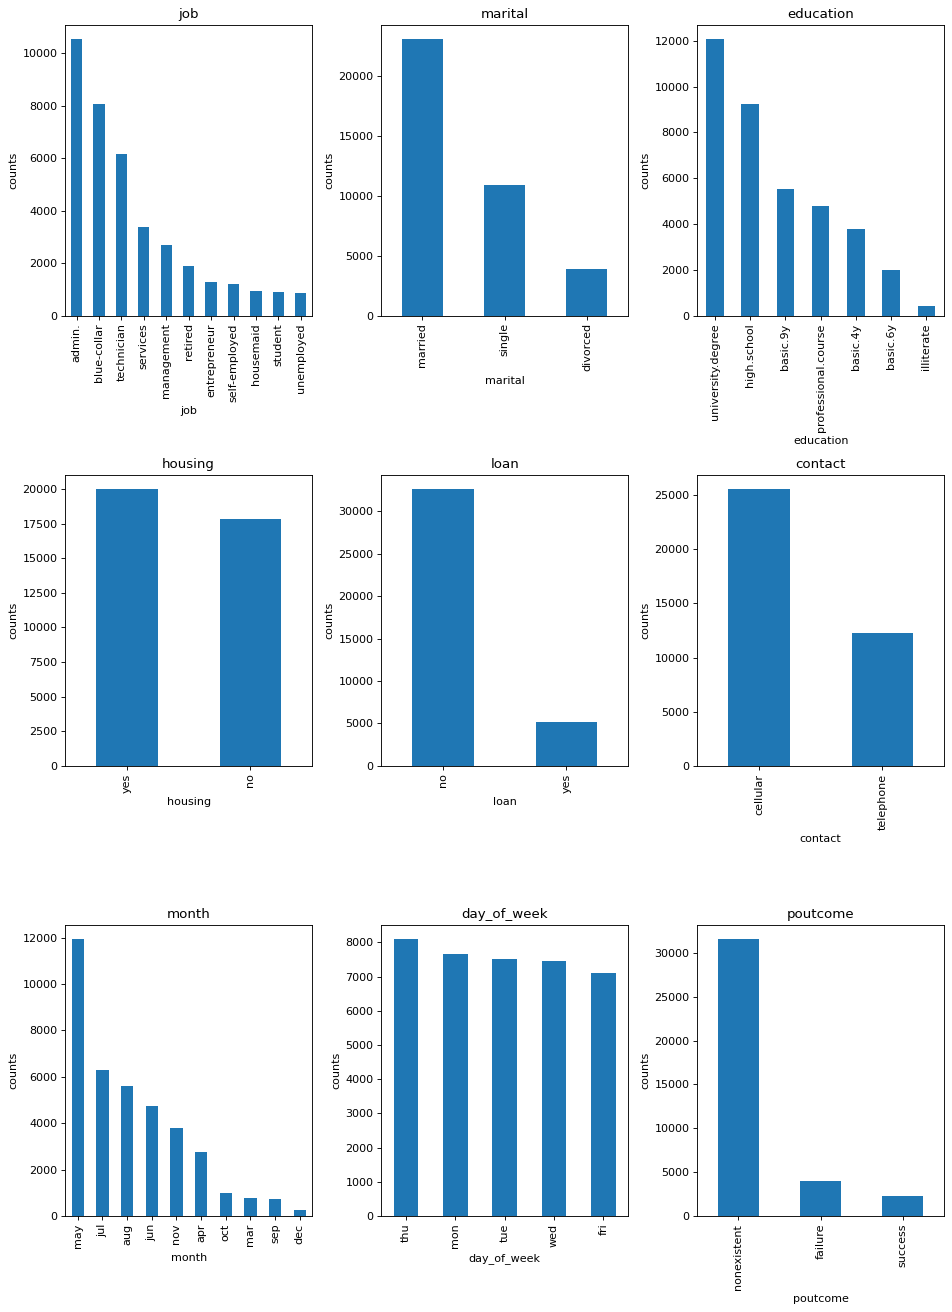

In [48]:
object_cols = X_train.select_dtypes(include = ['object']).columns
plotColumnCounts(X_train, object_cols, number_graphs_per_row=3)

Encoding strategy for each column:
- job: TargetEncoder (TE)
- marital: OneHotEncoder (OHE) with 'married' as baseline
- education: TE
- housing: OHE with 'yes' as baseline
- loan: OHE with 'yes' as baseline
- contact: OHE with 'cellular' as baseline
- month: Te
- day_of_week: TE
- poutcome: OHE with 'nonexistent' as baseline

In [49]:
ohe_features = {'marital': 'married',
                'housing': 'yes',
                'loan': 'yes',
                'contact': 'cellular',
                'poutcome': 'nonexistent'} # keys are column names, values are baseline values
te_features = ['job', 'education', 'month', 'day_of_week']
num_features = ['age', 'campaign', 'pdays_binary', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [50]:
# double check the above has correct spelling
for column, value in ohe_features.items():
    print(f"{column}/{value}: Column: {column in X_train.columns} | Value: {value in np.unique(X_train[column])}")

marital/married: Column: True | Value: True
housing/yes: Column: True | Value: True
loan/yes: Column: True | Value: True
contact/cellular: Column: True | Value: True
poutcome/nonexistent: Column: True | Value: True


In [51]:
# create column transformer
column_encoder = ColumnTransformer(
    transformers = [
        ('OHE', OneHotEncoder(sparse_output=False, drop = list(ohe_features.values())), list(ohe_features.keys())),
        ('TE', Pipeline([ # want to both TE, then scale
            ('target_encoder', TargetEncoder()),
            ('scaler', StandardScaler())
            ]), te_features),
        ('scaler', StandardScaler(), num_features)
    ],
    remainder = 'drop'
)

## <span class='bold-underline'>Problem 7: A Baseline Model</span>

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [52]:
y_train.value_counts(normalize=True)

y
0    0.749974
1    0.250026
Name: proportion, dtype: float64

Without knowing the cost-benefit ratio between the cost of marketing and the payoff from a single customer purchasing the service, it is hard to identify the bast metric for judging models by. The baseline accuracy should be at least 75%, since the majority class is 75%. The authors of the provided paper use the ROC curve, which compares 1 - Specificity (or False Positive Rate) to Recall (True Positive Rate). I will use the same metric, but it is hard to identify a baseline with the AUC of a ROC.

## <span class='bold-underline'>Problem 8: A Simple Model</span>

Use Logistic Regression to build a basic model on your data.

In [53]:
from sklearn.linear_model import LogisticRegression

# below: grid_search to find best 

logpipe = Pipeline([
    ('encode', column_encoder),
    ('log', LogisticRegression(random_state = 42))
])

# search over different penalty options
log_grid = {'log__penalty': ['l1', 'l2', None],
            'log__solver': ['liblinear', 'lbfgs']}

logsearch = GridSearchCV(logpipe, log_grid, cv=5, scoring='accuracy', verbose=1)

logsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Pyt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(transformers=[('OHE',
                                                                         OneHotEncoder(drop=['married',
                                                                                             'yes',
                                                                                             'yes',
                                                                                             'cellular',
                                                                                             'nonexistent'],
                                                                                       sparse_output=False),
                                                                         ['marital',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'poutcome']),
                                                                        ('TE',
                                                                         Pipeline(steps=[('target_encoder',
                                                                                          TargetEncoder()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['job',
                                                                          'education',
                                                                          'month',
                                                                          'day_of_week']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays_binary',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed'])])),
                                       ('log',
                                        LogisticRegression(random_state=42))]),
             param_grid={'log__penalty': ['l1', 'l2', None],
                         'log__solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [54]:
logsearch.best_estimator_.get_params()

{'memory': None,
 'steps': [('encode', ColumnTransformer(transformers=[('OHE',
                                    OneHotEncoder(drop=['married', 'yes', 'yes',
                                                        'cellular',
                                                        'nonexistent'],
                                                  sparse_output=False),
                                    ['marital', 'housing', 'loan', 'contact',
                                     'poutcome']),
                                   ('TE',
                                    Pipeline(steps=[('target_encoder',
                                                     TargetEncoder()),
                                                    ('scaler', StandardScaler())]),
                                    ['job', 'education', 'month', 'day_of_week']),
                                   ('scaler', StandardScaler(),
                                    ['age', 'campaign', 'pdays_binary', 'previous',


Best model: L2 regularization

## <span class='bold-underline'>Problem 9: Score the Model</span>

What is the accuracy of your model?

In [55]:
print(f"Train accuracy: {logsearch.score(X_train, y_train)} | Test accuracy: {logsearch.score(X_test, y_test)}")

Train accuracy: 0.8246276539558466 | Test accuracy: 0.8245484313932608


In [56]:
logmodel = logsearch.best_estimator_['log']
logencoder = logsearch.best_estimator_['encode']
pd.DataFrame({'feature': logencoder.get_feature_names_out(), 'coefficient': logmodel.coef_[0], 'coef_abs': np.abs(logmodel.coef_[0])}).sort_values(['coef_abs'], ascending = False)

,feature,coefficient,coef_abs
15,scaler__emp.var.rate,-1.481806,1.481806
4,OHE__contact_telephone,-1.206368,1.206368
16,scaler__cons.price.idx,0.976685,0.976685
19,scaler__nr.employed,0.584560,0.584560
3,OHE__loan_no,0.556386,0.556386
0,OHE__marital_divorced,-0.512442,0.512442
5,OHE__poutcome_failure,-0.496989,0.496989
6,OHE__poutcome_success,0.302013,0.302013
13,scaler__pdays_binary,-0.290715,0.290715
18,scaler__euribor3m,-0.281551,0.281551


**Results**:
Accuracy of ~82%. Strongest predictors are:
- (Negative) `emp.var.rate` (employment variation index)
- (Negative) `contact_telephone` (a OHE model, with the baseline being a cell phone--meaning that contacting someone on the telephone means they are less likely to purchase the service)
- `cons.price.idx` (consumer price index; positively related)
- `nr.employed` (number of employees)
- `loan_no` (whether someone has a loan; someone with no loan was more likely to purchase the service than someone who had a loan already)

To reduce dimensionality, we could drop `housing`.

### <span class='bold-underline'>Visualize Results</span>

In [57]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

y_pred = logsearch.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7983
           1       0.46      0.74      0.57      1484

    accuracy                           0.82      9467
   macro avg       0.70      0.79      0.73      9467
weighted avg       0.87      0.82      0.84      9467



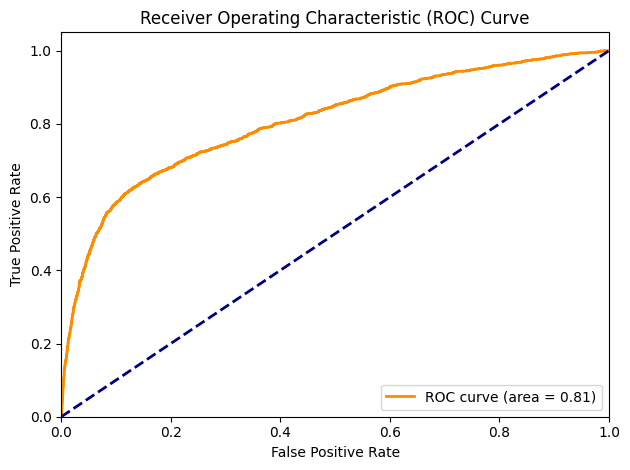

In [58]:
# Get predicted probabilities
y_pred_prob = logsearch.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot curves
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## <span class='bold-underline'>Problem 10: Model Comparisons</span>

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import datetime

# Set up all the pipelines at the same time
knn_pipe = Pipeline([
    ('encode', column_encoder),
    ('knn', KNeighborsClassifier())
])

dt_pipe = Pipeline([
    ('encode', column_encoder),
    ('dt', DecisionTreeClassifier(random_state = 42))
])

svm_pipe = Pipeline([
    ('encode', column_encoder),
    ('svc', SVC(random_state = 42))
])

# run the pipes
pipe_dict = {'knn': knn_pipe, 'dt': dt_pipe, 'svc': svm_pipe}
run_times = {}
train_acc_dict = {}
test_acc_dict = {}

for analysis in ['knn', 'dt', 'svc']:
    start_time = datetime.datetime.now()
    pipe_dict[analysis].fit(X_train, y_train)
    run_times[analysis] = datetime.datetime.now() - start_time
    train_acc_dict[analysis] = pipe_dict[analysis].score(X_train, y_train)
    test_acc_dict[analysis] = pipe_dict[analysis].score(X_test, y_test)

In [60]:
compare_frame = pd.DataFrame({
    'Model': ['KNN', 'Decision Tree', 'SVM'],
    'Train Time (Seconds)': np.array(run_times.values()),
    'Train Accuracy': list(train_acc_dict.values()),
    'Test Accuracy': list(test_acc_dict.values())
})
compare_frame

,Model,Train Time (Seconds),Train Accuracy,Test Accuracy
0,KNN,0:00:00.138416,0.884414,0.837118
1,Decision Tree,0:00:00.283145,0.995167,0.847048
2,SVM,0:00:44.757416,0.841951,0.837858


With the default settings, DT had almost perfect accuracy, which suggests it was overfit. All the models had comparable accuracy scores; let's compare ROC curves, too.

In [61]:
pipe_dict['knn'].predict_proba(X_test)

array([[0. , 1. ],
       [0. , 1. ],
       [0.8, 0.2],
       ...,
       [0. , 1. ],
       [0.4, 0.6],
       [0.4, 0.6]])

In [62]:
analysis

'svc'

In [63]:
roc_dict = {}
roc_auc_dict = {}

for analysis in ['knn', 'dt', 'svc']:
    if analysis == 'svc':
        y_pred_prob = pipe_dict[analysis].decision_function(X_test) 
    else:
        y_pred_prob = pipe_dict[analysis].predict_proba(X_test)[:, 1]
    roc_dict[analysis] = roc_curve(y_test, y_pred_prob)
    roc_auc_dict[analysis] = roc_auc_score(y_test, y_pred_prob)

In [64]:
roc_dict

{'knn': (array([0.        , 0.01661972, 0.05098592, 0.10957746, 0.20633803,
         0.41056338, 1.        ]),
  array([0.        , 0.3130545 , 0.51880017, 0.67722856, 0.80143642,
         0.91170258, 1.        ]),
  array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])),
 'dt': (array([0.        , 0.10056338, 0.10056338, 0.10098592, 0.10633803,
         0.10633803, 0.10746479, 1.        ]),
  array([0.        , 0.68990283, 0.69032531, 0.69117026, 0.70173215,
         0.7025771 , 0.70299958, 1.        ]),
  array([       inf, 1.        , 0.75      , 0.66666667, 0.5       ,
         0.4       , 0.33333333, 0.        ])),
 'svc': (array([0.        , 0.        , 0.        , ..., 0.99957746, 0.99957746,
         1.        ]),
  array([0.00000000e+00, 4.22475708e-04, 5.91465991e-03, ...,
         9.99577524e-01, 1.00000000e+00, 1.00000000e+00]),
  array([        inf,  1.91831396,  1.57631716, ..., -2.17493556,
         -2.18404   , -2.25772736]))}

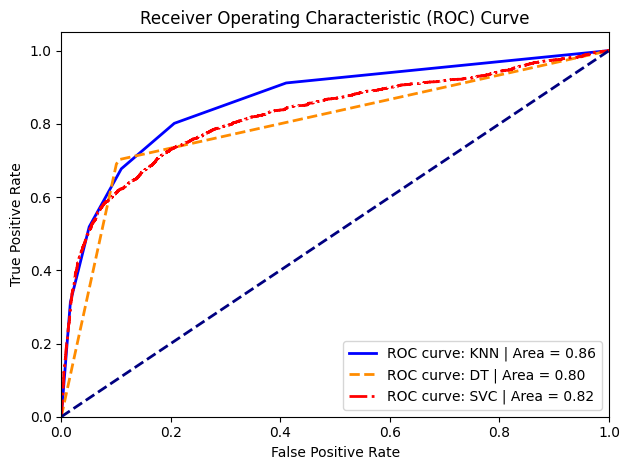

In [65]:
color_dict = {'knn': 'blue', 'dt': 'darkorange', 'svc': 'red'}
linestyle_dict = {'knn': 'solid', 'dt': 'dashed', 'svc': 'dashdot'}
# Plot curves
plt.figure()
for analysis in ['knn', 'dt', 'svc']:
    fpr, tpr, thresholds = roc_dict[analysis]
    roc_auc = roc_auc_dict[analysis]
    plt.plot(fpr, tpr, color=color_dict[analysis], linestyle = linestyle_dict[analysis], lw = 2, label=f'ROC curve: {analysis.upper()} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## <span class='bold-underline'>Problem 11: Improving the Model</span>

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### <span class='bold-underline'>Check for low-performing features<span>

Create a DataFrame comparing the coefficients for all of the features and their coefficients, then see if any patterns emerge.

In [66]:
# visualize logistic regression
pd.DataFrame({'feature': logencoder.get_feature_names_out(), 'log_coefficient': logmodel.coef_[0], 'log_coef_abs': np.abs(logmodel.coef_[0])}).sort_values(['log_coef_abs'], ascending = False).set_index('feature')

,log_coefficient,log_coef_abs
feature,,
scaler__emp.var.rate,-1.481806,1.481806
OHE__contact_telephone,-1.206368,1.206368
scaler__cons.price.idx,0.976685,0.976685
scaler__nr.employed,0.584560,0.584560
OHE__loan_no,0.556386,0.556386
OHE__marital_divorced,-0.512442,0.512442
OHE__poutcome_failure,-0.496989,0.496989
OHE__poutcome_success,0.302013,0.302013
scaler__pdays_binary,-0.290715,0.290715


In [67]:
# get KNN metrics
pipe_dict['knn']['knn'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [68]:
pipe_dict['dt'][:-1].get_feature_names_out()

array(['OHE__marital_divorced', 'OHE__marital_single', 'OHE__housing_no',
       'OHE__loan_no', 'OHE__contact_telephone', 'OHE__poutcome_failure',
       'OHE__poutcome_success', 'TE__job', 'TE__education', 'TE__month',
       'TE__day_of_week', 'scaler__age', 'scaler__campaign',
       'scaler__pdays_binary', 'scaler__previous', 'scaler__emp.var.rate',
       'scaler__cons.price.idx', 'scaler__cons.conf.idx',
       'scaler__euribor3m', 'scaler__nr.employed'], dtype=object)

In [69]:
# DT decision model
from sklearn.tree import export_graphviz
import graphviz

dt_data = export_graphviz(pipe_dict['dt']['dt'], out_file=None, 
                      feature_names=pipe_dict['dt'][:-1].get_feature_names_out(),
                      class_names=["No", "Yes"],  
                      filled=True, rounded=True)
graph = graphviz.Source(dt_data)
graph.render(format="png", filename="base_dt_model")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.103935 to fit


'base_dt_model.png'

In [70]:
# SVC metrics
pipe_dict['svc']['svc'].get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

**Summary**: DT model is obviously overfit and too complicated to review easily, and KNN and SVC models don't offer any inherent methods for identifying best predictors, outside of permutation importance.

For now, don't drop anything; only one had a logistic regression coefficient with abs value < .01 and it's not worth taking the time to remake column_transformer and other associated objects.

### <span class='bold-underline'>Hyperparameter tuning & grid search</span>

Already did grid search for logistic regression. Identify other hyperparameters for other models and run GridSearch.

Based on previous experimentation, running `HalvingRandomSearchCV()` multiple times and taking the best value yields the best results, so I'll do that this time, too.

In [71]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
import warnings
import time
import pickle
import random

best_models_dict = {'log': logsearch} # will save best models here

#### <span class='bold-underline'>DT</span>

In [72]:
%%script false ## Already ran this once and the results are saved in a file, which is imported below. Took ~ 5 minutes to run in total.

# improving decision tree. Use .cost_complexity_pruning_path to identify good ccp_alpha values to try. Keep where impurities between .1 and .2 (to avoid overfitting)
dt_alphas = pipe_dict['dt']['dt'].cost_complexity_pruning_path(pipe_dict['dt']['encode'].transform(X_test), y_test)
dt_alphas = dt_alphas['ccp_alphas'][(.1 < dt_alphas['impurities']) & (dt_alphas['impurities'] < .2)]

dt_alphas = pipe_dict['dt']['dt'].cost_complexity_pruning_path(pipe_dict['dt']['encode'].transform(X_test), y_test)['ccp_alphas']

dt_pipe_for_grid = Pipeline([
    ('encode', column_encoder),
    ('dt', DecisionTreeClassifier(random_state = 42))
])

dt_params = {'dt__ccp_alpha': dt_alphas}

dt_dict = {
    'acc_score': [],
    'randomsearch_model': {}
}

# turn off warnings; not always enough category in `y_train`
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# strategy: use the faster Randomized version for testing these alpha parameters
random.seed(42)
for i in range(100):
    temp_grid = HalvingRandomSearchCV(dt_pipe_for_grid, param_distributions = dt_params, scoring = 'accuracy', cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42),
                                  factor = 2, min_resources = "smallest", max_resources = 30, n_jobs = -1)
    temp_grid.fit(X_train, y_train)
    dt_dict['acc_score'].append(temp_grid.score(X_test, y_test))
    dt_dict['randomsearch_model'][i] = temp_grid.best_estimator_
    if i%5 == 0:
        print(f'Loop {i} completed. Time: {time.strftime("%H:%M:%S", time.localtime(time.time()))}')

# turn warnings back on
warnings.resetwarnings()

# save dict as JSON file, so I don't lose it
with open('dt_dict.pkl', 'wb') as f:
    pickle.dump(dt_dict, f)

Couldn't find program: 'false'


In [73]:
with open('dt_dict.pkl', 'rb') as f:
    dt_dict = pickle.load(f)

In [74]:
np.where(dt_dict['acc_score'] == np.max(dt_dict['acc_score']))

(array([32, 40], dtype=int64),)

In [75]:
dt_dict['acc_score'][32]

0.8721875990282032

In [76]:
dt_dict['randomsearch_model'][32].get_params()['steps']

[('encode',
  ColumnTransformer(transformers=[('OHE',
                                   OneHotEncoder(drop=['married', 'yes', 'yes',
                                                       'cellular',
                                                       'nonexistent'],
                                                 sparse_output=False),
                                   ['marital', 'housing', 'loan', 'contact',
                                    'poutcome']),
                                  ('TE',
                                   Pipeline(steps=[('target_encoder',
                                                    TargetEncoder()),
                                                   ('scaler', StandardScaler())]),
                                   ['job', 'education', 'month', 'day_of_week']),
                                  ('scaler', StandardScaler(),
                                   ['age', 'campaign', 'pdays_binary', 'previous',
                                    'e

In [77]:
print(f"Depth: {dt_dict['randomsearch_model'][32]['dt'].get_depth()} | Leaves: {dt_dict['randomsearch_model'][32]['dt'].get_n_leaves()}")

Depth: 30 | Leaves: 431


In [78]:
best_models_dict['dt'] = dt_dict['randomsearch_model'][32]

**DT Best Model**:
- Best ccp_alpha: 7.922256258582444e-05
- Depth: 30 | Leaves: 431
- Accuracy: 87%

### <span class='bold-underline'>KNN</span>

In [79]:
%%script false ## Already ran this once and the results are saved in a file, which is imported below. Took ~ 4 minutes to run in total.

# improving KNN

knn_pipe_for_grid = Pipeline([
    ('encode', column_encoder),
    ('knn', KNeighborsClassifier())
])

knn_params = {'knn__n_neighbors': range(145, 245), # n_neighbors set to +/- 50 from the sqrt of # of observations in X_train (~195)
              'knn__weights': ['uniform', 'distance']}

knn_dict = {
    'acc_score': [],
    'randomsearch_model': {}
}

# turn off warnings; not always enough category in `y_train`
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# strategy: use the faster Randomized version for testing these alpha parameters
random.seed(42)
for i in range(100):
    temp_grid = HalvingRandomSearchCV(knn_pipe_for_grid, param_distributions = knn_params, scoring = 'accuracy', cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42),
                                  factor = 2, min_resources = "smallest", max_resources = 30, n_jobs = -1)
    temp_grid.fit(X_train, y_train)
    knn_dict['acc_score'].append(temp_grid.score(X_test, y_test))
    knn_dict['randomsearch_model'][i] = temp_grid.best_estimator_
    if i%5 == 0:
        print(f'Loop {i} completed. Time: {time.strftime("%H:%M:%S", time.localtime(time.time()))}')

# turn warnings back on
warnings.resetwarnings()

# save dict as JSON file, so I don't lose it
with open('knn_dict.pkl', 'wb') as f:
    pickle.dump(knn_dict, f)

Couldn't find program: 'false'


In [80]:
with open('knn_dict.pkl', 'rb') as f:
    knn_dict = pickle.load(f)

In [81]:
np.where(knn_dict['acc_score'] == np.max(knn_dict['acc_score']))

(array([28], dtype=int64),)

In [82]:
knn_dict['acc_score'][28]

0.8321537974015

In [83]:
knn_dict['randomsearch_model'][28].get_params()['steps']

[('encode',
  ColumnTransformer(transformers=[('OHE',
                                   OneHotEncoder(drop=['married', 'yes', 'yes',
                                                       'cellular',
                                                       'nonexistent'],
                                                 sparse_output=False),
                                   ['marital', 'housing', 'loan', 'contact',
                                    'poutcome']),
                                  ('TE',
                                   Pipeline(steps=[('target_encoder',
                                                    TargetEncoder()),
                                                   ('scaler', StandardScaler())]),
                                   ['job', 'education', 'month', 'day_of_week']),
                                  ('scaler', StandardScaler(),
                                   ['age', 'campaign', 'pdays_binary', 'previous',
                                    'e

In [84]:
best_models_dict['knn'] = dt_dict['randomsearch_model'][28]

**KNN Best Model**:
- Best parameters: 'n_neighbors' = 147, weights = 'distance'
- Accuracy: 83%

### <span class='bold-underline'>SVC</span>

In [85]:
%%script false ## Already ran this once and the results are saved in a file, which is imported below. Took ~ 1 hour to run in total.

# improving SVM
svc_pipe_for_grid = Pipeline([
    ('encode', column_encoder),
    ('svc', SVC(random_state = 42))
])

svc_params = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__kernel': ['rbf'],
    'svc__gamma': [0.01, 0.1, 1, 10, 100]
}

svc_dict = {
    'acc_score': [],
    'randomsearch_model': {}
}

# turn off warnings; not always enough category in `y_train`
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# strategy: use the faster Randomized version for testing these alpha parameters
random.seed(42)
for i in range(30):
    temp_grid = HalvingRandomSearchCV(svc_pipe_for_grid, param_distributions = svc_params, scoring = 'accuracy', cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42),
                                      factor = 2, min_resources = "smallest", max_resources = 30, n_jobs = -1)
    temp_grid.fit(X_train, y_train)
    svc_dict['acc_score'].append(temp_grid.score(X_test, y_test))
    svc_dict['randomsearch_model'][i] = temp_grid.best_estimator_
    print(f'Loop {i} completed. Time: {time.strftime("%H:%M:%S", time.localtime(time.time()))}')

# turn warnings back on
warnings.resetwarnings()

# save dict as JSON file, so I don't lose it
with open('svc_dict.pkl', 'wb') as f:
    pickle.dump(svc_dict, f)

Couldn't find program: 'false'


In [86]:
with open('svc_dict.pkl', 'rb') as f:
    svc_dict = pickle.load(f)

In [87]:
np.where(svc_dict['acc_score'] == np.max(svc_dict['acc_score']))

(array([14, 28], dtype=int64),)

In [88]:
svc_dict['acc_score'][14], svc_dict['acc_score'][28]

(0.843878736664202, 0.843878736664202)

In [89]:
svc_dict['randomsearch_model'][14].get_params()['steps']

[('encode',
  ColumnTransformer(transformers=[('OHE',
                                   OneHotEncoder(drop=['married', 'yes', 'yes',
                                                       'cellular',
                                                       'nonexistent'],
                                                 sparse_output=False),
                                   ['marital', 'housing', 'loan', 'contact',
                                    'poutcome']),
                                  ('TE',
                                   Pipeline(steps=[('target_encoder',
                                                    TargetEncoder()),
                                                   ('scaler', StandardScaler())]),
                                   ['job', 'education', 'month', 'day_of_week']),
                                  ('scaler', StandardScaler(),
                                   ['age', 'campaign', 'pdays_binary', 'previous',
                                    'e

In [90]:
svc_dict['randomsearch_model'][28].get_params()['steps']

[('encode',
  ColumnTransformer(transformers=[('OHE',
                                   OneHotEncoder(drop=['married', 'yes', 'yes',
                                                       'cellular',
                                                       'nonexistent'],
                                                 sparse_output=False),
                                   ['marital', 'housing', 'loan', 'contact',
                                    'poutcome']),
                                  ('TE',
                                   Pipeline(steps=[('target_encoder',
                                                    TargetEncoder()),
                                                   ('scaler', StandardScaler())]),
                                   ['job', 'education', 'month', 'day_of_week']),
                                  ('scaler', StandardScaler(),
                                   ['age', 'campaign', 'pdays_binary', 'previous',
                                    'e

In [91]:
best_models_dict['svc'] = svc_dict['randomsearch_model'][28]

**SVC Best Model**:
- Best parameters: C = 10, gamma = 0.1 
- Accuracy: 84%

### <span class='bold-underline'>Visualize Best Models</span>

In [92]:
roc_dict = {}
roc_auc_dict = {}
best_acc_dict = {}

for analysis in ['knn', 'dt', 'svc', 'log']:
    if analysis == 'svc':
        y_pred_prob = best_models_dict[analysis].decision_function(X_test) 
    else:
        y_pred_prob = best_models_dict[analysis].predict_proba(X_test)[:, 1]
    roc_dict[analysis] = roc_curve(y_test, y_pred_prob)
    roc_auc_dict[analysis] = roc_auc_score(y_test, y_pred_prob)
    best_acc_dict[analysis] = best_models_dict[analysis].score(X_test, y_test)

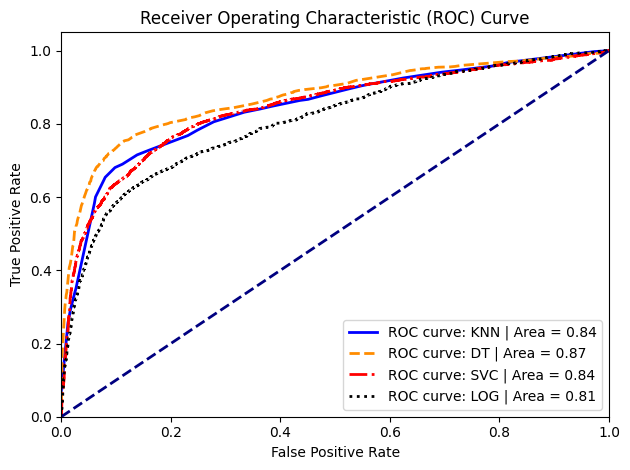

In [93]:
color_dict = {'knn': 'blue', 'dt': 'darkorange', 'svc': 'red', 'log': 'black'}
linestyle_dict = {'knn': 'solid', 'dt': 'dashed', 'svc': 'dashdot', 'log': 'dotted'}
# Plot curves
plt.figure()
for analysis in ['knn', 'dt', 'svc', 'log']:
    fpr, tpr, thresholds = roc_dict[analysis]
    roc_auc = roc_auc_dict[analysis]
    plt.plot(fpr, tpr, color=color_dict[analysis], linestyle = linestyle_dict[analysis], lw = 2, label=f'ROC curve: {analysis.upper()} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('images/ROC_final.png')
plt.show()

In [94]:
## DataFrame of accuracy scores
accuracy_frame = pd.DataFrame({'Model': [s.upper() for s in list(best_acc_dict.keys())], 'Accuracy Score': list(best_acc_dict.values())}).sort_values(['Accuracy Score'], ascending = False)
accuracy_frame

,Model,Accuracy Score
1,DT,0.872188
0,KNN,0.853174
2,SVC,0.843879
3,LOG,0.824548


## <span class='bold-underline'>Conclusions</span>

In [95]:
dt_coefs = pd.DataFrame({'feature': best_models_dict['dt']['encode'].get_feature_names_out(), 'dt_coef': best_models_dict['dt']['dt'].feature_importances_,
                      'dt_abs_coef': np.abs(best_models_dict['dt']['dt'].feature_importances_)}).sort_values('dt_abs_coef', ascending = False).set_index('feature')
log_coefs = pd.DataFrame({'feature': logencoder.get_feature_names_out(), 'log_coef': logmodel.coef_[0],
                          'log_abs_coef': np.abs(logmodel.coef_[0])}).sort_values(['log_abs_coef'], ascending = False).set_index('feature')

In [96]:
dt_coefs['dt_rank'] = range(20, 0, -1)
log_coefs['log_rank'] = range(20, 0, -1)

all_coefs = pd.concat([dt_coefs, log_coefs], axis = 1)
all_coefs['avg_rank'] = (all_coefs['dt_rank'] + all_coefs['log_rank']) / 2
all_coefs = all_coefs.sort_values('avg_rank', ascending = False)
all_coefs

,dt_coef,dt_abs_coef,dt_rank,log_coef,log_abs_coef,log_rank,avg_rank
feature,,,,,,,
scaler__nr.employed,0.363610,0.363610,20,0.584560,0.584560,17,18.5
OHE__contact_telephone,0.027981,0.027981,13,-1.206368,1.206368,19,16.0
scaler__euribor3m,0.289151,0.289151,19,-0.281551,0.281551,11,15.0
TE__month,0.063274,0.063274,17,0.262084,0.262084,10,13.5
scaler__cons.price.idx,0.006349,0.006349,9,0.976685,0.976685,18,13.5
scaler__pdays_binary,0.035274,0.035274,14,-0.290715,0.290715,12,13.0
scaler__emp.var.rate,0.002844,0.002844,4,-1.481806,1.481806,20,12.0
OHE__loan_no,0.004803,0.004803,8,0.556386,0.556386,16,12.0
scaler__campaign,0.063808,0.063808,18,-0.038037,0.038037,4,11.0


There was similar predictive power across models. The logistic regression model performed the most poorly, with an accuracy of 83% and a ROC-AUC value of 0.81. The decision tree model performed the best, with an accuracy of 87% and an ROC-AUC metric of 0.87.

The DT model has a depth of 30 and 431 leaves. Given how many features and observations we have, I don't think this results in overfitting, and the high scores of the model supports that belief.

Based on the results of the decision tree and logistic regression models, there are some variables much more important than others in making decisions.
- Economic context variables, such as employee variation rate (`emp.var.rate`), euribor 3 month rate (`euribor3m`), and consumer price index (`con.price.idx`), and are some of the strongest predictors. These likely correlate strongly with consumer's confidence in the economy, which affects their willingness to purchase economic services.
- Variables possibly related to time of year--e.g., number of employees (`nr.employed`) and month of year (`month`) are important predictors. The bank should look further into this and identify why this may be the case.
- Other strong indicators are likely corrlated with wealth. For example, method of contact (`contact`): those contacted via a telephone were less likely to purchase the service than those contacted via cell phone, and those who purchased services previously were more likely to purchase this service. However, those who did not have a loan were *more* likely to purchase the service, so there are some unanswered questions about how customer profiles relate to whether they'll purchase a service or not.
- Given that the strongest predictors correlate with consumer's willingness and capacity to invest, it would probably be useful to also look at factors such as the balance of customers' open accounts. Given the patterns observed, it is likely that those with higher balances would be more likely to purchase services.
